## 1) Charger les données

In [1]:
import os, sys
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import random
from collections import Counter
from collections import defaultdict

2024-10-16 15:00:07.760654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 15:00:08.649297: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 15:00:08.871630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 15:00:10.329723: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 15:00:14.664040: W tensorflow/compiler/tf2

In [ ]:
"""
path = os.getcwd()
path = os.path.join(path, "art-challenge", "images_hq")

list_peintre = os.listdir(path)
data = []

for peintre in list_peintre:
    path_peintre = os.path.join(path, peintre)
    list_peinture = os.listdir(path_peintre)
    for peinture in list_peinture:
        img = plt.imread(os.path.join(path, peintre, peinture))
        data.append([img, peintre])
"""

In [ ]:
# Définir le chemin du dossier contenant les images
path = os.getcwd()
path = os.path.join(path, "art-challenge", "images_lq")

# Obtenir la liste de toutes les images dans le dossier
list_images = os.listdir(path)
data = []

# Boucle à travers chaque image
for image_file in list_images:
    # Séparer l'artiste du reste du nom de fichier (enlever l'extension)
    artiste = '_'.join(image_file.split('_')[:-1])  # Récupérer tout avant le dernier underscore "_"
    
    # Lire l'image
    img = plt.imread(os.path.join(path, image_file))
    
    # Vérifier si l'image est en niveaux de gris (2 dimensions)
    if len(img.shape) == 2:
        # Si l'image est en niveaux de gris, la convertir en RGB en dupliquant les canaux
        img = np.stack((img,)*3, axis=-1)  # Cela crée un canal RGB en dupliquant l'image en niveaux de gris
    
    # Ajouter l'image et le nom complet de l'artiste au dataset
    data.append([img, artiste])

# Le dataset "data" contient maintenant chaque image avec 3 canaux RGB et le nom complet de l'artiste

# Exemple de vérification
print(np.shape(data[0][0]))

In [3]:
import os
import matplotlib.pyplot as plt

# Définir le chemin du dossier contenant les images
path = os.getcwd()
path = os.path.join(path, "art-challenge", "images_lq")

# Obtenir la liste de toutes les images dans le dossier
list_images = os.listdir(path)
data = []

# Boucle à travers chaque image
for image_file in list_images:
    # Séparer l'artiste du reste du nom de fichier (enlever l'extension)
    artiste = '_'.join(image_file.split('_')[:-1])  # Récupérer tout avant le dernier underscore "_"
    
    # Lire l'image
    img = plt.imread(os.path.join(path, image_file))
    
    # Ajouter l'image et le nom complet de l'artiste au dataset
    data.append([img, artiste])

# Le dataset "data" contient maintenant chaque image et le nom complet de l'artiste


In [8]:
print(np.shape(data[0][0]))

(614, 432)


In [2]:
def afficher_images_aleatoires(data, nombre_images=5):
    """
    Affiche un certain nombre d'images aléatoires avec leurs labels.

    Args:
    - data: Liste contenant des paires [image, artiste].
    - nombre_images: Nombre d'images à afficher (par défaut 5).
    """
    # Sélectionner des échantillons aléatoires dans la liste data
    images_aleatoires = random.sample(data, nombre_images)

    # Créer une figure avec une taille adaptée
    plt.figure(figsize=(15, 5))

    for i, (img, artiste) in enumerate(images_aleatoires):
        # Créer un sous-plot pour chaque image
        plt.subplot(1, nombre_images, i + 1)
        plt.imshow(img)
        plt.title(artiste)
        plt.axis('off')  # Masquer les axes

    # Afficher les images
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
afficher_images_aleatoires(data)

NameError: name 'data' is not defined

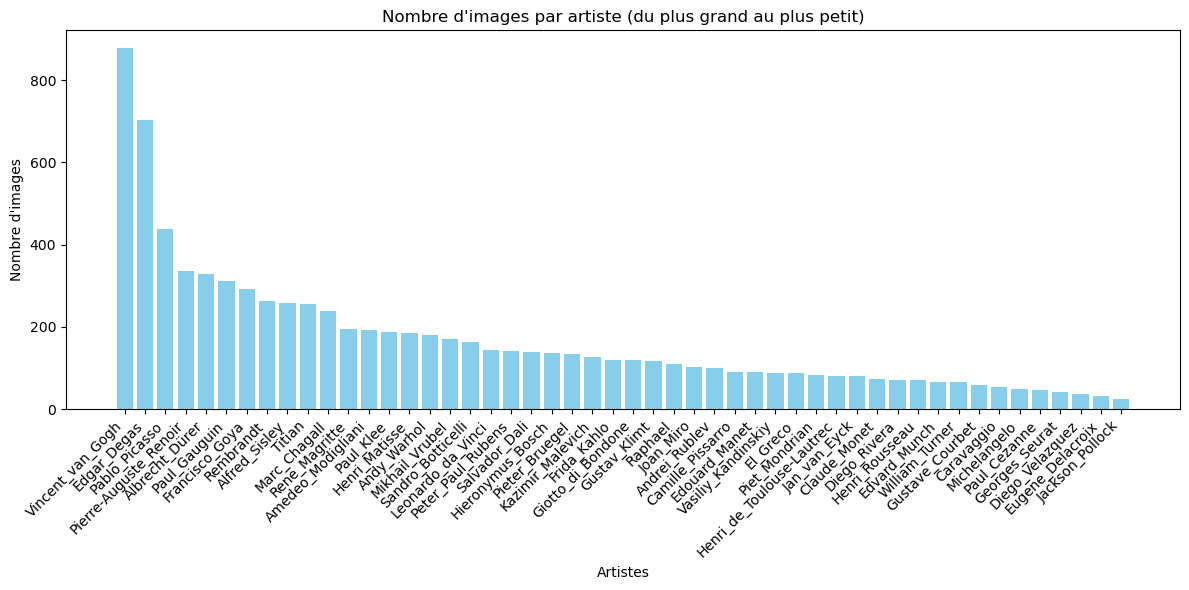

In [11]:
def histogramme_images_par_artiste(data):
    """
    Affiche un histogramme du nombre d'images par artiste, trié du plus grand au plus petit.

    Args:
    - data: Liste contenant des paires [image, artiste].
    """
    # Extraire la liste des artistes à partir de la liste de données
    artistes = [artiste for _, artiste in data]

    # Compter le nombre d'images pour chaque artiste
    compte_artistes = Counter(artistes)

    # Trier les artistes par nombre d'images, du plus grand au plus petit
    artistes_tries = sorted(compte_artistes.items(), key=lambda x: x[1], reverse=True)
    noms_artistes = [artiste for artiste, _ in artistes_tries]
    nombre_images = [nb_images for _, nb_images in artistes_tries]

    # Créer l'histogramme
    plt.figure(figsize=(12, 6))
    plt.bar(noms_artistes, nombre_images, color='skyblue')

    # Rotation des labels pour une meilleure lisibilité
    plt.xticks(rotation=45, ha='right')

    # Ajouter les labels et le titre
    plt.xlabel('Artistes')
    plt.ylabel('Nombre d\'images')
    plt.title('Nombre d\'images par artiste (du plus grand au plus petit)')

    # Afficher l'histogramme
    plt.tight_layout()  # Pour ajuster l'espacement et éviter les chevauchements
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
histogramme_images_par_artiste(data)

Désiquilibré : data augmentation sur les plus petits ? ou enlever quand y en a trop

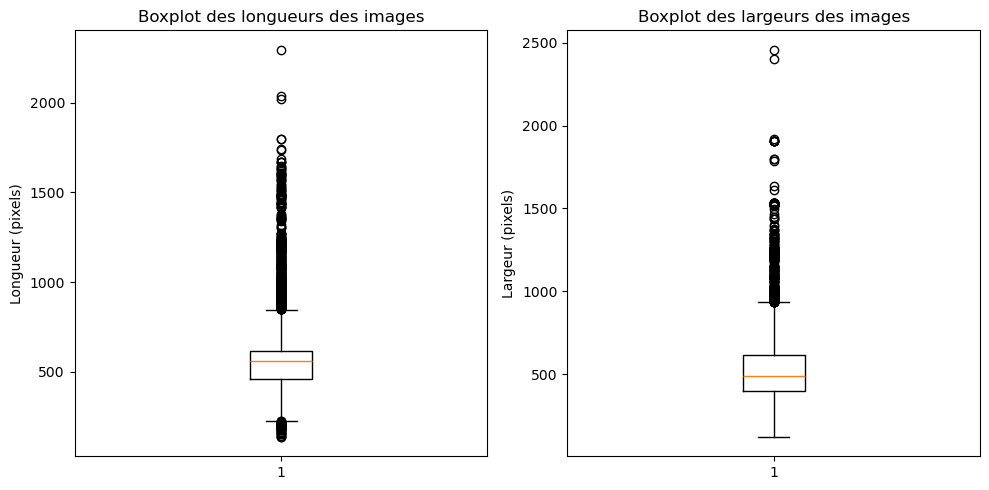

In [12]:


def boxplot_dimensions_images(data):
    """
    Affiche un boxplot des longueurs et des largeurs des images dans le dataset.

    Args:
    - data: Liste contenant des paires [image, artiste].
    """
    # Extraire les longueurs et largeurs des images
    longueurs = [img.shape[0] for img, _ in data]  # Hauteur des images
    largeurs = [img.shape[1] for img, _ in data]   # Largeur des images

    # Créer un boxplot pour les longueurs
    plt.figure(figsize=(10, 5))

    # Boxplot pour les longueurs
    plt.subplot(1, 2, 1)
    plt.boxplot(longueurs)
    plt.title('Boxplot des longueurs des images')
    plt.ylabel('Longueur (pixels)')

    # Boxplot pour les largeurs
    plt.subplot(1, 2, 2)
    plt.boxplot(largeurs)
    plt.title('Boxplot des largeurs des images')
    plt.ylabel('Largeur (pixels)')

    # Afficher les boxplots
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
boxplot_dimensions_images(data)


On va resize toutes les images en 512*512 (*3) A recheck après enlever des artistes.

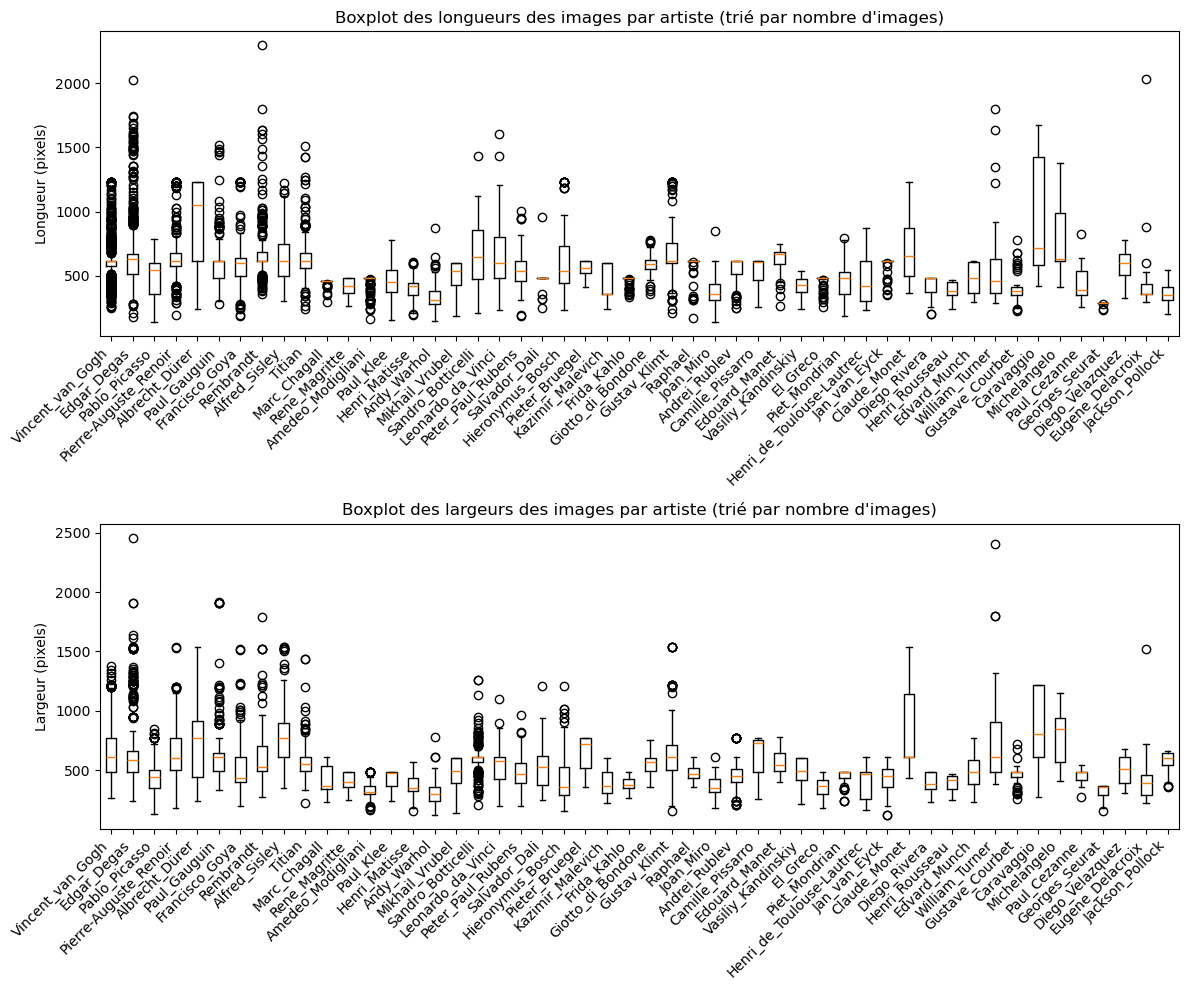

In [18]:
def boxplot_dimensions_par_artiste(data):
    """
    Affiche des boxplots des longueurs et largeurs des images pour chaque artiste, 
    trié par ordre décroissant du nombre d'images.

    Args:
    - data: Liste contenant des paires [image, artiste].
    """
    # Initialiser des dictionnaires pour stocker les longueurs et largeurs par artiste
    longueurs_par_artiste = defaultdict(list)
    largeurs_par_artiste = defaultdict(list)

    # Parcourir les données pour remplir les longueurs et largeurs par artiste
    for img, artiste in data:
        longueurs_par_artiste[artiste].append(img.shape[0])  # Hauteur des images
        largeurs_par_artiste[artiste].append(img.shape[1])   # Largeur des images

    # Compter le nombre d'images pour chaque artiste
    compte_artistes = Counter([artiste for _, artiste in data])

    # Trier les artistes par nombre d'images, du plus grand au plus petit
    artistes_tries = sorted(compte_artistes.items(), key=lambda x: x[1], reverse=True)
    artistes = [artiste for artiste, _ in artistes_tries]

    # Récupérer les longueurs et largeurs triées par artiste
    longueurs = [longueurs_par_artiste[artiste] for artiste in artistes]
    largeurs = [largeurs_par_artiste[artiste] for artiste in artistes]

    # Créer une figure plus grande et étalée
    plt.figure(figsize=(12, 10))  # Augmenter la taille verticale

    # Boxplot pour les longueurs par artiste (en haut)
    plt.subplot(2, 1, 1)  # 2 lignes, 1 colonne, 1er subplot
    plt.boxplot(longueurs, labels=artistes)
    plt.xticks(rotation=45, ha='right')
    plt.title('Boxplot des longueurs des images par artiste (trié par nombre d\'images)')
    plt.ylabel('Longueur (pixels)')

    # Boxplot pour les largeurs par artiste (en bas)
    plt.subplot(2, 1, 2)  # 2 lignes, 1 colonne, 2e subplot
    plt.boxplot(largeurs, labels=artistes)
    plt.xticks(rotation=45, ha='right')
    plt.title('Boxplot des largeurs des images par artiste (trié par nombre d\'images)')
    plt.ylabel('Largeur (pixels)')

    # Ajuster la disposition et afficher
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
boxplot_dimensions_par_artiste(data)

In [ ]:
import matplotlib.image as mpimg
from skimage.transform import resize

def redimensionner_images(data, nouvelle_taille=(512, 512, 3)):
    """
    Redimensionne les images dans le dataset à une nouvelle taille.

    Args:
    - data: Liste contenant des paires [image, artiste].
    - nouvelle_taille: Tuple représentant la nouvelle taille (hauteur, largeur, canaux).
    
    Returns:
    - data_redimensionne: Liste contenant des paires [image redimensionnée, artiste].
    """
    data_redimensionne = []
    for img, artiste in data:
        img_redim = resize(img, nouvelle_taille, anti_aliasing=True)
        data_redimensionne.append([img_redim, artiste])
    
    return data_redimensionne

def afficher_images_aleatoires_avant_apres(data, data_redimensionne, nombre_images=5):
    """
    Affiche 5 images aléatoires avant et après redimensionnement avec leurs labels.

    Args:
    - data: Liste d'images originales et leurs labels.
    - data_redimensionne: Liste d'images redimensionnées et leurs labels.
    - nombre_images: Nombre d'images à afficher.
    """
    # Sélectionner des échantillons aléatoires dans la liste data
    indices_aleatoires = random.sample(range(len(data)), nombre_images)

    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices_aleatoires):
        # Image et artiste avant redimensionnement
        img_originale, artiste = data[idx]
        # Image après redimensionnement
        img_redim, _ = data_redimensionne[idx]

        # Afficher l'image originale
        plt.subplot(2, nombre_images, i + 1)
        plt.imshow(img_originale)
        plt.title(f'Originale: {artiste}')
        plt.axis('off')

        # Afficher l'image redimensionnée
        plt.subplot(2, nombre_images, i + 1 + nombre_images)
        plt.imshow(img_redim)
        plt.title(f'Redimensionnée: {artiste}')
        plt.axis('off')

    # Afficher les images
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
data_redimensionne = redimensionner_images(data)
afficher_images_aleatoires_avant_apres(data, data_redimensionne)
